In [1]:
import anndata
import seaborn as sns
import matplotlib.pyplot as plt

import sopa

heatmap_kwargs = {"vmax": 40, "cmap": sns.cm.rocket_r, "cbar_kws": {'label': 'Mean hop distance'}}

## 1. Prepare your data

You'll need the `AnnData` output of Sopa. If using the `SpatialData` object itself, simply extract the table.

Make sure you have at least a cell-type annotation (i.e. a column in `adata.obs` corresponding to cell-types), and eventually a niche annotation (with algorithms such as [Novae](https://github.com/MICS-Lab/novae)).

#### (Optional) Download the tutorial data

The `.h5ad` file used in this tutorial is publicly available on Zenodo [here](https://doi.org/10.5281/zenodo.10512440).

In [2]:
adata = anndata.read_h5ad("adata_liver_merscope.h5ad")

Then, compute the Delaunay graph on your data. Especially, use the `radius` argument to drop long edges. In this examples, edges longer than 50 microns are removed.
> The later function comes from [Squidpy](https://squidpy.readthedocs.io/en/latest/api/squidpy.gr.spatial_neighbors.html#squidpy.gr.spatial_neighbors).

In [3]:
sopa.spatial.spatial_neighbors(adata, radius=[0, 50])

[INFO] (sopa.spatial._build) Computing delaunay graph


## 2. Distances between cell categories

You can compute the mean hop-distance between all pairs of cell-types:
> Below, `'cell_type'` is the name of the column of `adata.obs` containing the cell-type annotation

In [4]:
cell_type_to_cell_type = sopa.spatial.mean_distance(adata, "cell_type", "cell_type")

100%|██████████| 28/28 [00:08<00:00,  3.36it/s]


<Axes: xlabel='cell_type', ylabel='cell_type'>

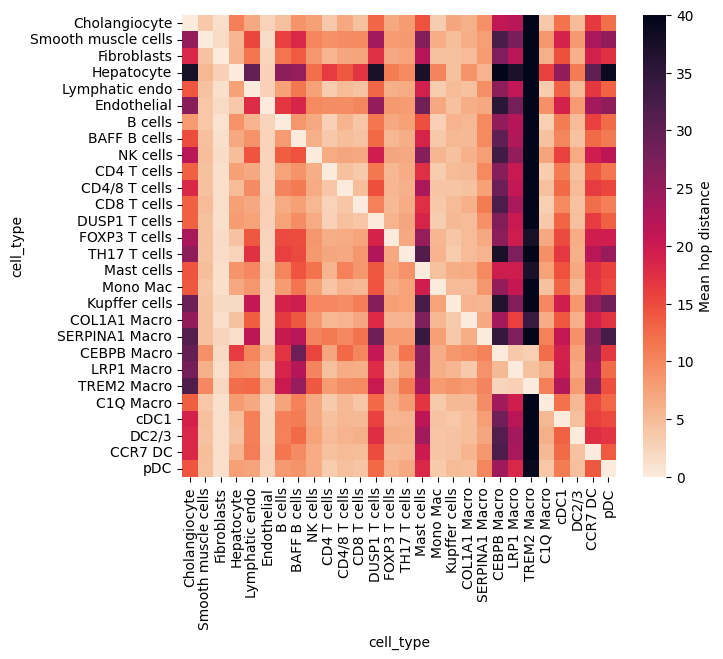

In [5]:
plt.figure(figsize=(7, 6))
sns.heatmap(cell_type_to_cell_type, **heatmap_kwargs)

Similary, you can compute the mean hop-distance between all pairs of cell-types and niches:

In [6]:
cell_type_to_niche = sopa.spatial.mean_distance(adata, "cell_type", "niches")

100%|██████████| 8/8 [00:02<00:00,  3.41it/s]


<Axes: xlabel='niches', ylabel='cell_type'>

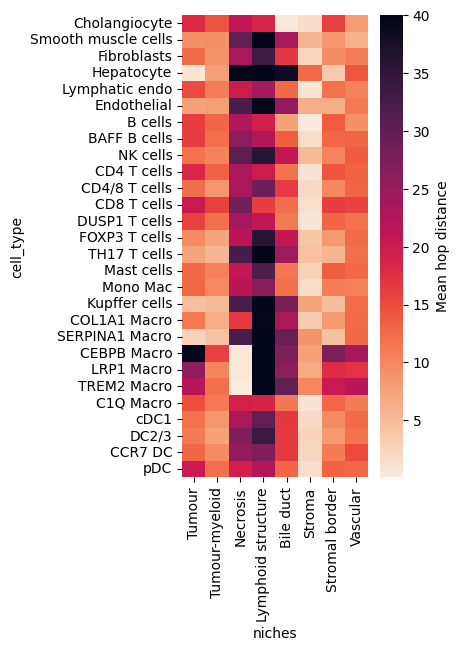

In [7]:
plt.figure(figsize=(3, 6))
sns.heatmap(cell_type_to_niche, **heatmap_kwargs)

Same between niches and niches:

In [8]:
niche_to_niche = sopa.spatial.mean_distance(adata, "niches")

100%|██████████| 8/8 [00:02<00:00,  3.44it/s]


<Axes: xlabel='niches', ylabel='niches'>

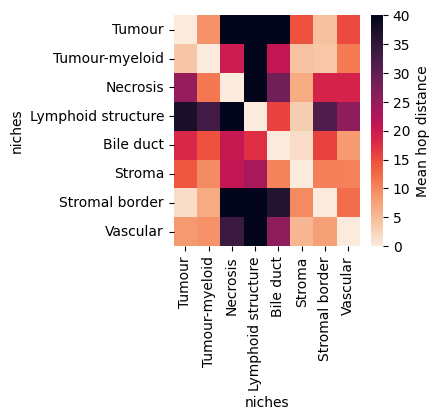

In [9]:
plt.figure(figsize=(3, 3))
sns.heatmap(niche_to_niche, **heatmap_kwargs)

## 3. Transform niches into shapes
If desired, niches can be transformed into [Shapely](https://shapely.readthedocs.io/en/stable/index.html) geometries. Each occurence of a specific niche will correspond to one Polygon. This makes efficient further operations on niches, such as the one in the next section.

In [10]:
gdf = sopa.spatial.geometrize_niches(adata, "niches")
gdf

,geometry,niches,length,area,roundness
0,"POLYGON ((11256.961 7834.639, 11257.304 7835.6...",Bile duct,371.136469,6941.104125,0.633244
3,"POLYGON ((11122.354 8163.108, 11123.162 8163.7...",Bile duct,393.638585,5539.287922,0.449230
6,"POLYGON ((10936.163 381.622, 10936.478 381.898...",Bile duct,1595.710237,24099.793633,0.118936
8,"POLYGON ((11021.489 747.492, 11019.723 748.834...",Bile duct,561.516074,5763.341860,0.229699
17,"POLYGON ((11042.181 3981.166, 11043.124 3980.8...",Bile duct,584.173216,6296.007422,0.231842
...,...,...,...,...,...
2292,"POLYGON ((2805.196 4508.688, 2805.687 4509.714...",Vascular,589.849425,13760.673500,0.497012
2370,"POLYGON ((459.355 560.935, 460.631 562.344, 46...",Vascular,727.372986,7949.503667,0.188815
2378,"POLYGON ((192.733 4605.956, 193.558 4606.628, ...",Vascular,601.631439,8236.973094,0.285967
2388,"POLYGON ((78.743 2939.361, 79.118 2940.362, 80...",Vascular,390.753989,8232.263635,0.677520


Now, each occurence (or connected component) of each niche category is a Polygon. On this example, the Necrosis niche has 3 components, as shown below.

<Axes: >

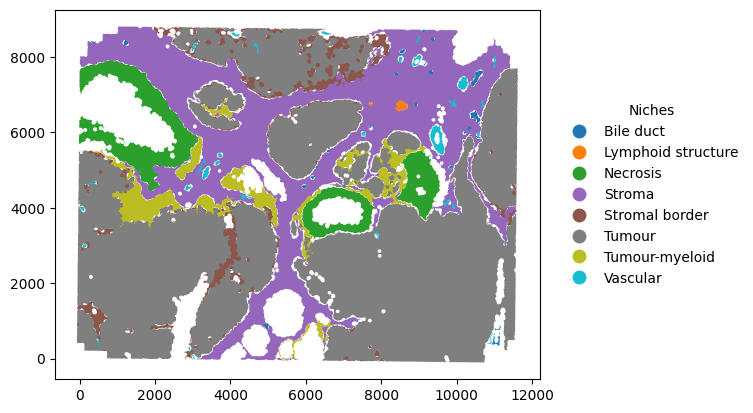

In [11]:
legend_kwds = {"bbox_to_anchor": (1.04, 0.5), "loc": "center left", "borderaxespad": 0, "frameon": False, "title": "Niches"}

gdf.plot(column="niches", legend=True, legend_kwds=legend_kwds)

## 4. Niches geometries
For each niche, we can compute geometric properties. Here, we computed some simple properties of each niche: their mean length (or perimeter), their mean area, and their mean roundness (score between 0 and 1, where high values means "circle"-like shape).

> NB: Since one niche can be divided into multiple connected components (or multiple occurences), we indeed need to average the above geometric properties over all connected components of one niche category

In [12]:
df_niches_geometries = sopa.spatial.niches_geometry_stats(adata, "niches")
df_niches_geometries

[INFO] (sopa.spatial.morpho) Computing pairwise distances between 118 components


,n_components,length,area,roundness,min_distance_to_niche_Bile duct,min_distance_to_niche_Lymphoid structure,min_distance_to_niche_Necrosis,min_distance_to_niche_Stroma,min_distance_to_niche_Stromal border,min_distance_to_niche_Tumour,min_distance_to_niche_Tumour-myeloid,min_distance_to_niche_Vascular
niches,,,,,,,,,,,,
Bile duct,53,871.163413,1.968860e+04,0.337805,0.000000,2380.538268,1449.461569,73.698113,606.466864,503.188672,1458.109531,554.878833
Lymphoid structure,2,1036.895946,6.074089e+04,0.655267,99.283752,0.000000,1293.705232,0.000000,484.004416,288.855609,778.042413,727.563948
Necrosis,3,14679.900601,1.859571e+06,0.144873,215.188214,2613.268586,0.000000,0.000000,530.994922,24.705659,0.000000,206.323638
Stroma,1,159551.459121,2.385822e+07,0.011777,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Stromal border,10,32107.645354,1.562288e+06,0.023618,1282.747393,4533.620464,1263.667065,356.928689,0.000000,0.000000,624.666420,365.469128
Tumour,8,22964.491358,6.363175e+06,0.178266,258.930767,2124.252221,433.590282,2.529358,40.851952,0.000000,257.084459,121.688532
Tumour-myeloid,13,5625.146904,2.741475e+05,0.116237,531.479998,3349.152789,603.320975,0.000000,332.532881,79.196333,0.000000,694.707711
Vascular,28,808.856057,2.111648e+04,0.403680,1065.886005,3766.261346,1702.920627,401.167661,477.280906,283.654705,1370.371248,0.000000


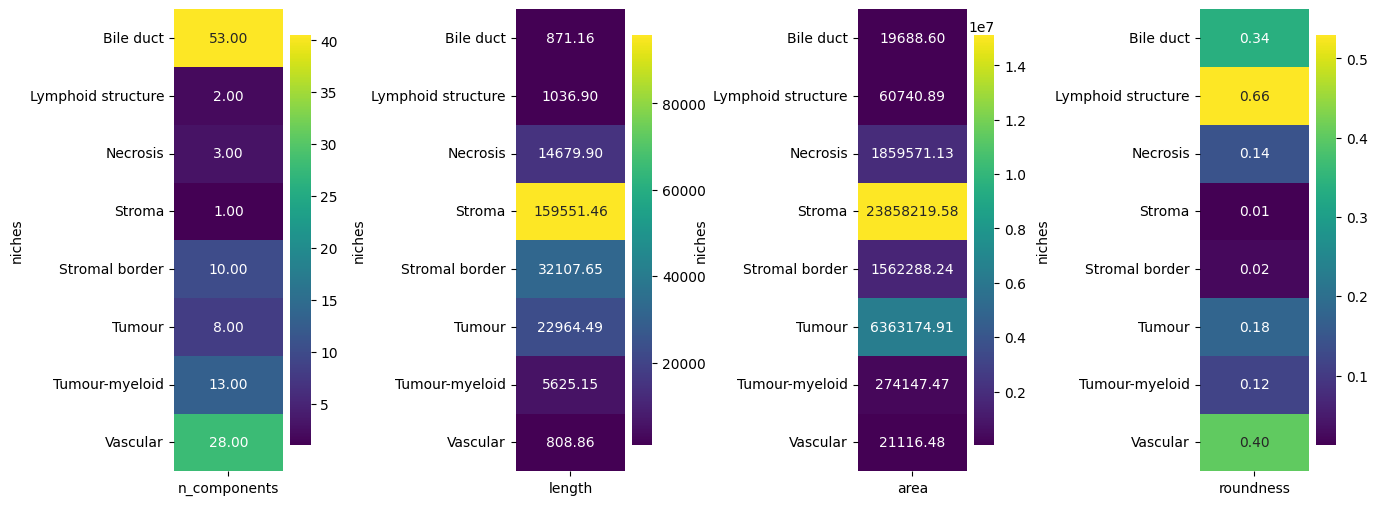

In [13]:
fig, axes = plt.subplots(1, 4, figsize=(15, 6))

for i, name in enumerate(["n_components", "length", "area", "roundness"]):
    vmax = df_niches_geometries[name].sort_values()[-2:].mean()
    sns.heatmap(df_niches_geometries[[name]], cmap="viridis", annot=True, fmt=".2f", vmax=vmax, ax=axes[i])

plt.subplots_adjust(wspace=1.5)

## 5. Cell-type / Niche network

The distances between cell-types and/or niches can be summerized into one network, and plot with the [Netgraph](https://netgraph.readthedocs.io/en/latest/index.html) library. It provides a quick overview of the interactions happening in the micro-environment of one slide.

To continue, you'll need to install Louvain and Netgraph:

```sh
!pip install python-louvain
!pip install netgraph
```

In [ ]:
import networkx as nx
from community import community_louvain
from netgraph import Graph

In [15]:
weights, node_color, node_size, node_shape = sopa.spatial.prepare_network(adata, "cell_type", "niches")

[INFO] (sopa.spatial.distance) Computing all distances for the 4 pairs of categories
100%|██████████| 8/8 [00:02<00:00,  3.48it/s]


In [16]:
g = nx.from_pandas_adjacency(weights)
node_to_community = community_louvain.best_partition(g, resolution=1.35)

/Users/quentinblampey/mambaforge/envs/spatial/lib/python3.10/site-packages/netgraph/_edge_layout.py:978: RuntimeWarning: invalid value encountered in divide
  displacement = compatibility * delta / distance_squared[..., None]
/Users/quentinblampey/mambaforge/envs/spatial/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


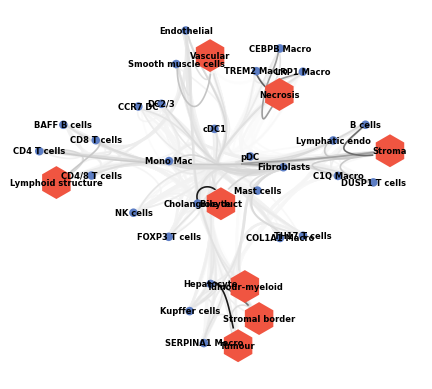

In [17]:
Graph(g,
      node_size=node_size,
      node_color=node_color,
      node_shape=node_shape,
      node_edge_width=0,
      node_layout='community',
      node_layout_kwargs=dict(node_to_community=node_to_community),
      node_labels=True,
      node_label_fontdict=dict(size=6, weight="bold"),
      edge_alpha=1,
      edge_width=0.5,
      edge_layout_kwargs=dict(k=2000),
      edge_layout='bundled',
)